# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: 44
* Students: Nikolai Orgland, Diego Debruyn, Yann Morize, Silvan Stettler
* Dataset: Swiss National Council

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline
import numpy as np

# Weighted adjacency matrix
adjacency_weighted = np.load("adjacency.npy")

# Binary matrices created using different thresholds
filenames = ["adjacency_0.1", "adjacency_0.3", "adjacency_0.5", "adjacency_0.7", "adjacency_0.9"]

adjacencies_binary =  [np.load(file+".npy") for file in filenames]
n_nodes =  np.asarray([a.shape[0] for a in adjacencies_binary])
n_edges =  np.asarray([np.sum(a)/2 for a in adjacencies_binary])
thresholds = np.linspace(0.1, 0.9, 5)

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency =  adjacency_weighted
n_nodes =  adjacency_weighted.shape[0]

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
k_i = np.sum(adjacency, axis=1)

row = np.arange(200)  # row coordinates
col = np.arange(200)  # column coordinates
D = sparse.coo_matrix((k_i, (row, col)), shape=(200,200))
D_sqrt = D.power(-0.5).toarray()
laplacian_combinatorial_array =  D.toarray()-adjacency 
laplacian_normalized_array =  D_sqrt @ laplacian_combinatorial_array @ D_sqrt 

In [5]:
# Store matrix in crs format
laplacian_combinatorial = scipy.sparse.csr_matrix(laplacian_combinatorial_array)
laplacian_normalized = scipy.sparse.csr_matrix(laplacian_normalized_array)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [6]:
laplacian =  laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [7]:
L=laplacian.toarray()

In [8]:
vals, vecs = np.linalg.eigh(L)
#eigenvalues are already sorted with this function
D = np.diag(vals)
#Test to verify eigendecomposition was done correctly
TEST = np.allclose(L,np.matrix(vecs) @ np.matrix(D) @ np.matrix(np.transpose(vecs)))

eigenvalues =  np.round(vals,10)
eigenvectors =  np.round(vecs,10)

assert eigenvectors.shape == (n_nodes, n_nodes)
print('The eigendeconmosition is correct: {0:}'.format(TEST))

The eigendeconmosition is correct: True


Justify your choice of eigensolver.

**We used numpy because spars format coudn't compute with a k higher than 198...**

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**S is the incidence matrix. $S^Tx$ gives us the gradient of x.**

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Considering the eigendecomposition of L**

**$\lambda_k = u_k^\top L u_k = u_k^\top S S^\top u_k = (S^\top u_k)^\top (S^\top u_k) = \| S^\top u_k \|_2^2$**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**$u_0$ is called the constant vector. As we can see on the plots below: the first eigenvector for the combinatorial Laplacian is constant. However the one for Normalized Laplacian has some small fluctuations. We think that this is due to approximations by computing the inverse roots of D given the very small fluctuations.**

Difference between max and min values of u0_norm = 0.03179


Text(0.5,1,'Eigenvector u0 from L combinatorial')

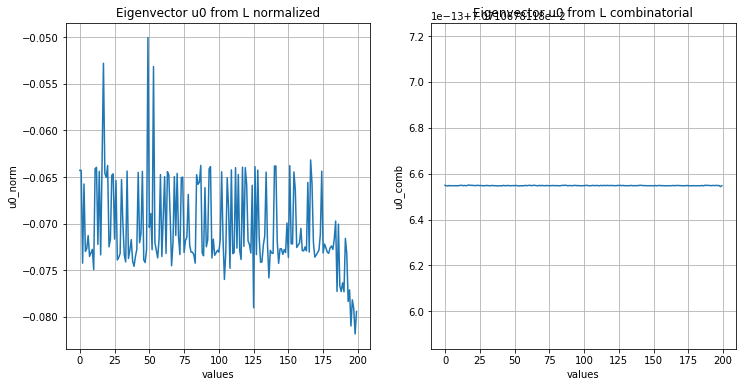

In [15]:
valsnorm, vecsnorm = np.linalg.eigh(laplacian_normalized_array)
valscomb, vecscomb = np.linalg.eigh(laplacian_combinatorial_array)

deviation = (np.max(vecsnorm[:,0]))-(np.min (vecsnorm[:,0]))
print('Difference between max and min values of u0_norm = {0:.5f}'.format(deviation))

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(row, vecsnorm[:,0])
plt.grid(True)
plt.xlabel('values')
plt.ylabel('u0_norm')
plt.title('Eigenvector u0 from L normalized')
plt.subplot(122)
plt.plot(row, vecscomb[:,0])
plt.grid(True)
plt.xlabel('values')
plt.ylabel('u0_comb')
plt.title('Eigenvector u0 from L combinatorial')


### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

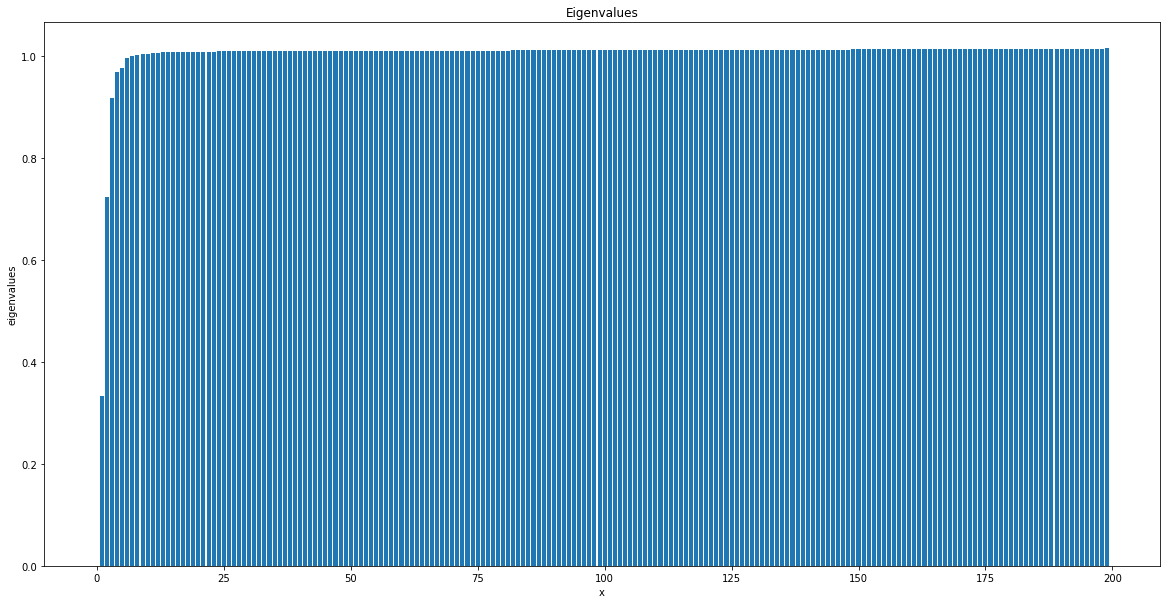

In [10]:
plt.figure(figsize=(20, 10))
plt.bar(row, eigenvalues)
plt.xlabel('x')
plt.ylabel('eigenvalues')
plt.title('Eigenvalues')
plt.show()

**There is one single minimum eigenvalue which is 0. Then the eigenvalues converge very fast to 1. There are two eigenvalues between 0 and 0.8. All the rest are very close to 1.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [11]:
connect = np.count_nonzero(eigenvalues == 0)
print ("The graph has {} connected component(s)".format(connect)) 

The graph has 1 connected component(s)


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**We have for the largest eigenvalue of the Normalized Laplacian: $\lambda_{N-1}= \frac{N}{N-1}$ for a complete graph and $\lambda_{N-1}=2$ for a bipartite graph. As see in the next cell our $\lambda_{N-1}$ is way closer to a complete graphe thant to a bipartite one.**

In [12]:
Complete_norm = n_nodes/(n_nodes-1)
lamb_norm = max (valsnorm)
Bipartite_norm= 2
print('N/(N-1) = {0:.3f}'.format(Complete_norm))
print('lambda_norm max = {0:.3f}'.format(lamb_norm))
print('Bipartie = {0}'.format(Bipartite_norm))
print()
print("Indeed: {0:.3f} < {1:.3f} < {2}" .format(Complete_norm, lamb_norm,Bipartite_norm))

N/(N-1) = 1.005
lambda_norm max = 1.015
Bipartie = 2

Indeed: 1.005 < 1.015 < 2


**For the combinatorial Laplacian: $\lambda_{N-1}= \frac{N}{N-1}*\Delta(G)$ for a complete graph and $\lambda_{N-1}=2*\Delta(G)$ for a bipartite graph. With $\Delta(G)=max (k_i).$**

In [16]:
Complete_comb=n_nodes/(n_nodes-1)* max(k_i)
lamb_comb = max (valscomb)
Bipartite_comb= 2*max(k_i)
print('N/(N-1)*∆(G) = {0:.3f}'.format(Complete_comb))
print('lambda_comb max = {0:3f}'.format(lamb_comb))
print("Bipartie = {0:.3f}".format(Bipartite_comb))
print()
print("Indeed: {0:.3f} < {1:.3f} < {2:.3f}".format(Complete_comb, lamb_comb,Bipartite_comb))


N/(N-1)*∆(G) = 118.587
lambda_comb max = 118.734728
Bipartie = 235.988

Indeed: 118.587 < 118.735 < 235.988


## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [ ]:
# Your code here.

Plot the nodes embedded in 2D. Comment on what you see.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
#Fiedler vecotr
plt.figure()
plt.title('Fiedler vector')
plt.plot(row, vecs[:,1]/k_i)

#2D embedding
fig, ax = plt.subplots()
test=vecs[:,1]<0

graph_d_3=vecs[:,0:3]
graph_d_3_norm=vecs[:,0:3]*np.power([D[1,1],D[2,2],D[3,3]],1/2)
ax.plot(graph_d_3[:,1],graph_d_3[:,2],'*g',label='regular')
ax.plot(graph_d_3_norm[:,1],graph_d_3_norm[:,2],'*r',label='re-normalizing')
plt.title('2D embeding')
ax.legend()

#Importing parties
real_clus=np.load('clustering.npy')
gauche=(real_clus == -1)
droite=(real_clus == 1)

#Clustering
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)

ax1.plot(graph_d_3[test,1],graph_d_3[test,2],'*b',label='cluster 1')
ax1.plot(graph_d_3[~test,1],graph_d_3[~test,2],'*r',label='cluster 2')
#plt.axes().set_aspect('equal', 'datalim')
ax1.legend()

ax2.plot(graph_d_3[gauche,1],graph_d_3[gauche,2],'*r',label='gauche')
ax2.plot(graph_d_3[droite,1],graph_d_3[droite,2],'*b',label='droite')
ax2.plot(graph_d_3[~(gauche|droite),1],graph_d_3[~(gauche|droite),2],'*y',label='reste')
ax2.legend()
#plt.axes().set_aspect('equal', 'datalim')

#three clusters
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True)
clustering = KMeans(n_clusters=3,random_state=0).fit(graph_d_3)
group1=(clustering.labels_==0)
group2=(clustering.labels_==1)
group3=(clustering.labels_==2)


ax1.plot(graph_d_3[group1,1],graph_d_3[group1,2],'*g',label='cluster 1')
ax1.plot(graph_d_3[group2,1],graph_d_3[group2,2],'*b',label='cluster 2')
ax1.plot(graph_d_3[group3,1],graph_d_3[group3,2],'*r',label='cluster 3')
#plt.axes().set_aspect('equal', 'datalim')
ax1.legend()

ax2.plot(graph_d_3[gauche,1],graph_d_3[gauche,2],'*b',label='gauche')
ax2.plot(graph_d_3[droite,1],graph_d_3[droite,2],'*r',label='droite')
ax2.plot(graph_d_3[~(gauche|droite),1],graph_d_3[~(gauche|droite),2],'*y',label='reste')
ax2.legend()


print(graph_d_3.shape)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.
cluster=test*1
order=np.argsort(cluster)
adjacency_temp=adjacency[:,order]
adjacency_temp=adjacency_temp[order,:]

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**